# Using Google Colab for this demo.
#### If you're not, just ignore the next cell

In [5]:
#Mount the drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/rain")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/rain'

# Import libraries

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn 

# Set data paths

In [0]:
path_dry = 'train_dry' #path to the dry images
path_wet = 'train_wet' #path to the wet images (images with rain)

il = ImageList.from_folder(path_wet)

# Set ResNet architecture and data loader

In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_wet).split_by_rand_pct(0.1, seed=42)

def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_dry/x.relative_to(path_wet))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

# Show some data
### Wet image on the left, clean image on the right

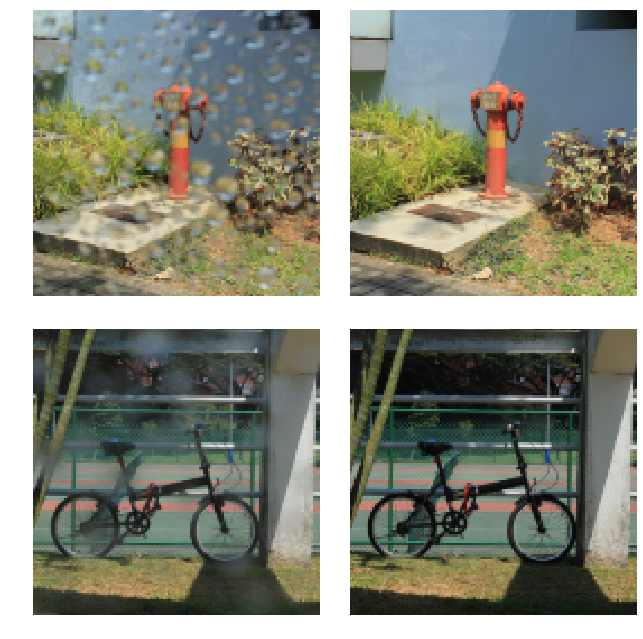

In [9]:
data = get_data(bs,size)
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

# Feature loss

In [10]:
t = data.valid_ds[0][1].data 
t = torch.stack([t,t])
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:12<00:00, 45553657.00it/s]


([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [12]:
wd = 1e-3 #weight decay
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 66485489.43it/s]


# Learning rate finder
#### Look for the steepest downhill (in my case it was around 1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


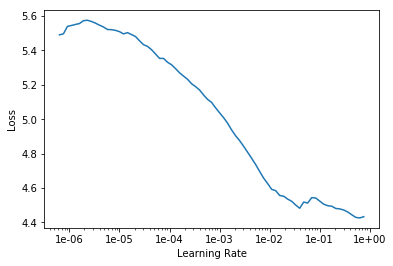

In [13]:
learn.lr_find()
learn.recorder.plot()

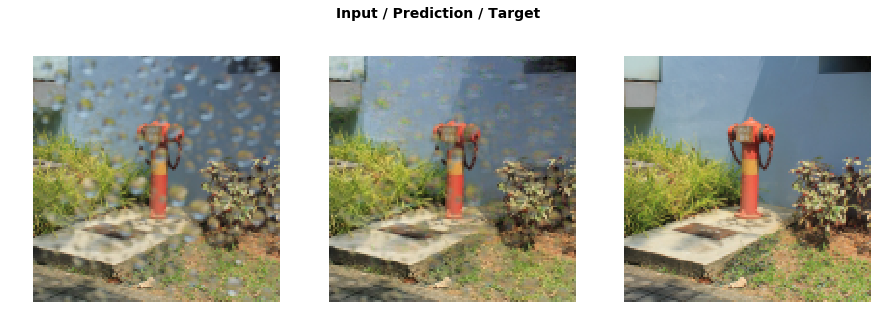

In [0]:
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(50, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)
do_fit('1a', slice(lr*10))

# Unfreeze and fit

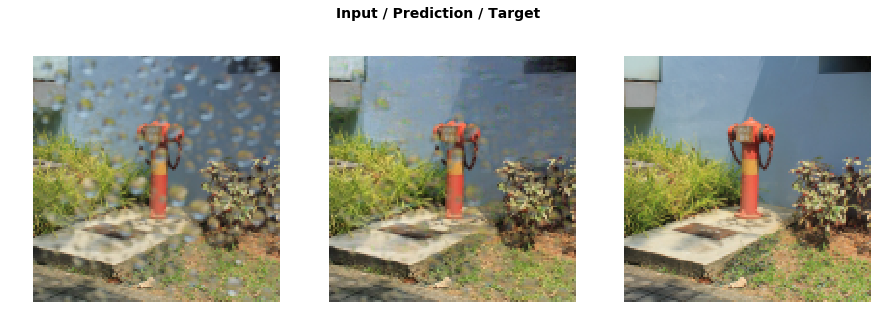

In [0]:
learn.unfreeze()
do_fit('1b', slice(1e-5,lr))

# Increase image size and fit again

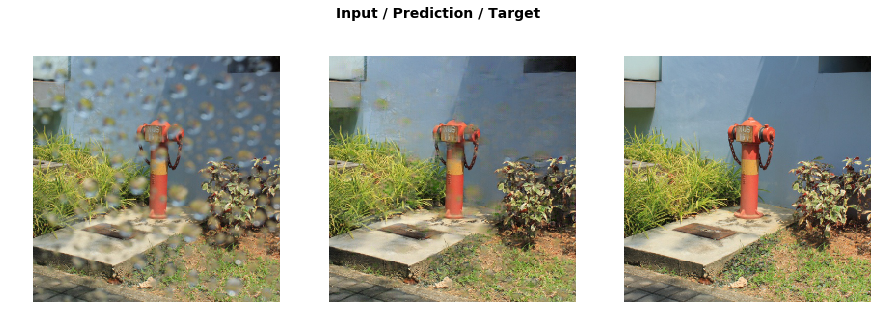

In [0]:
data = get_data(12,size*2)
learn.data = data
learn.freeze()
gc.collect()
learn.load('1b');
do_fit('2a')

# Unfreeze and fit 

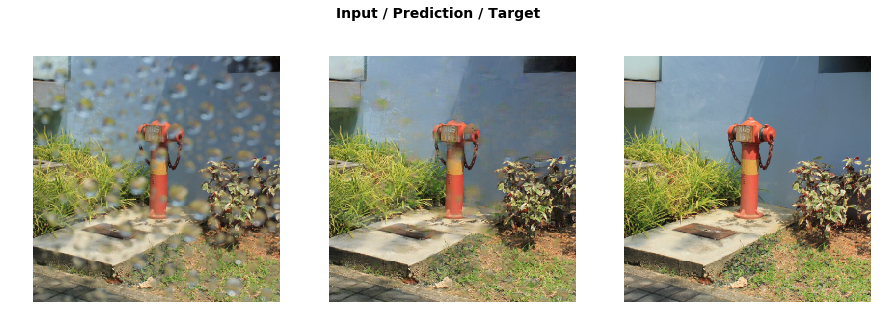

In [0]:
learn.unfreeze()
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

# Load the pretrained weights

#### Only if you're not doing the previous training step (otherwise it doesn't really matter)

In [0]:
learn.load('2b');

# Show some results

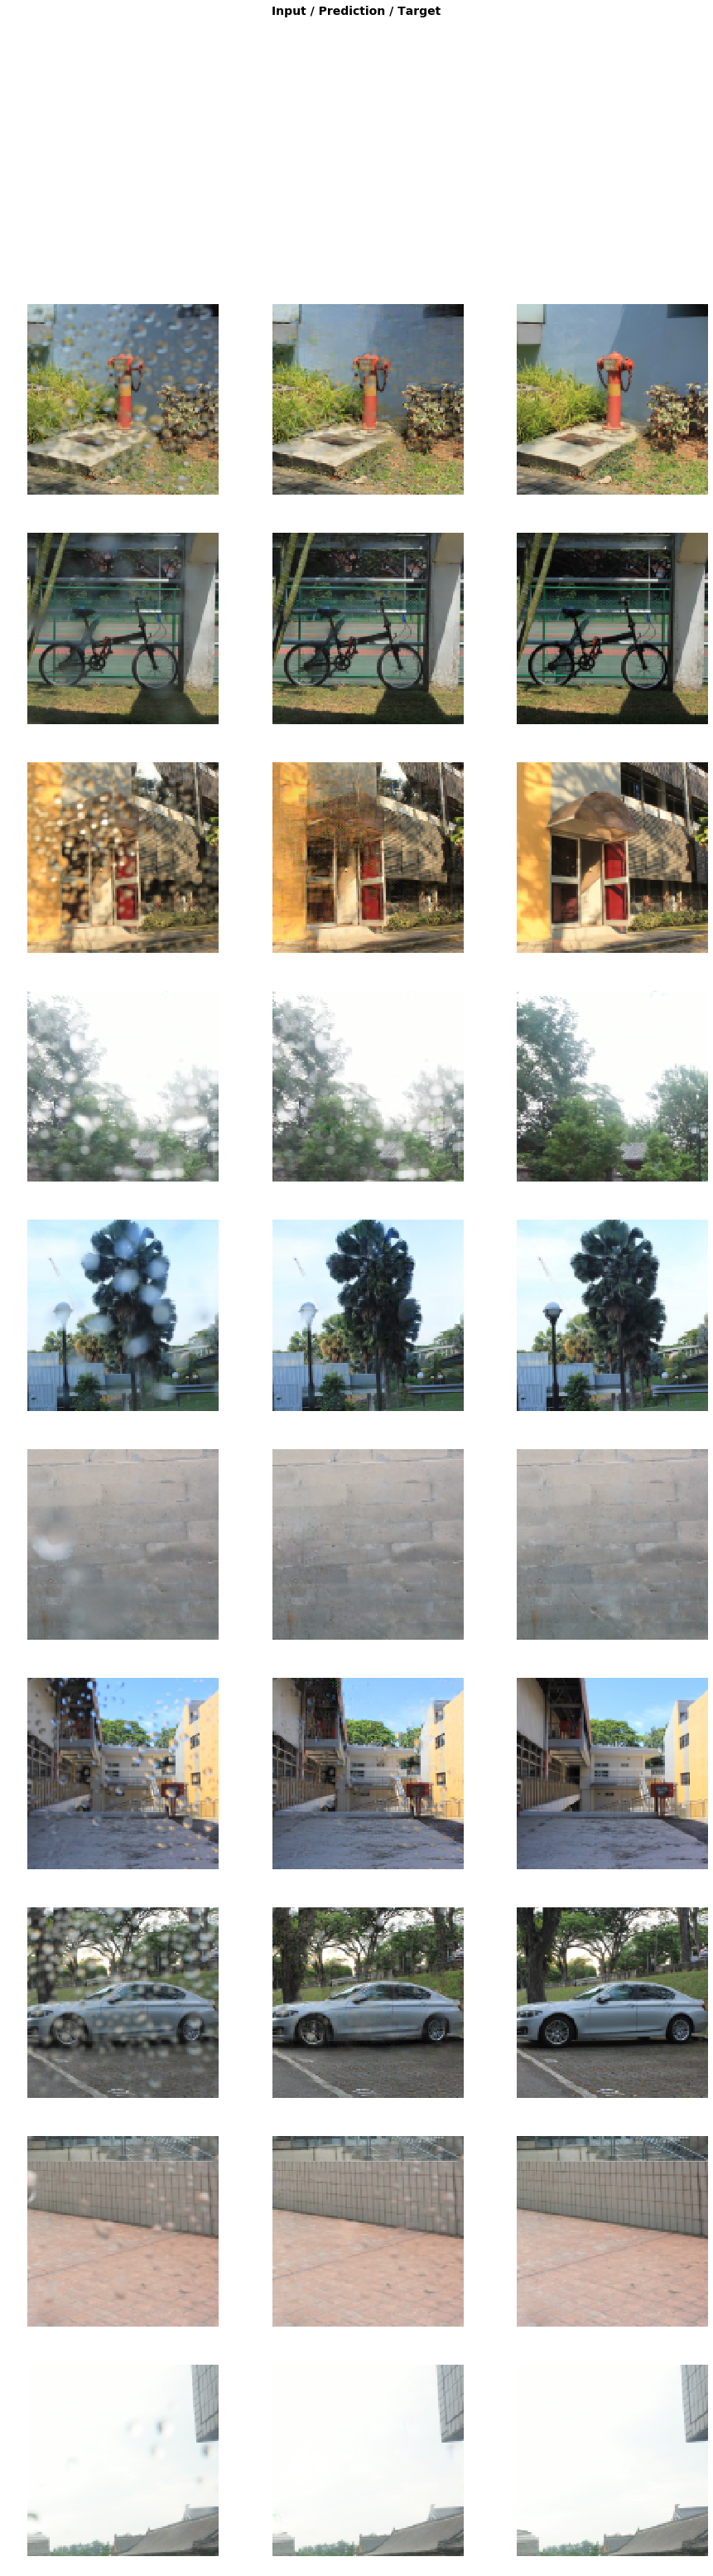

In [0]:
learn.show_results(rows=10, imgsize=5)

# Test

In [0]:
test_path='test_b/data'
data_transformer = (ImageImageList.from_folder(test_path).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: test_path/x.relative_to(test_path))
          .transform(get_transforms(), size=(820,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [0]:
learn.data = data_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


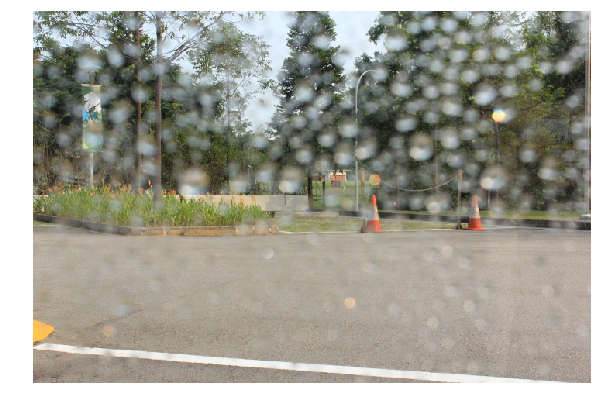

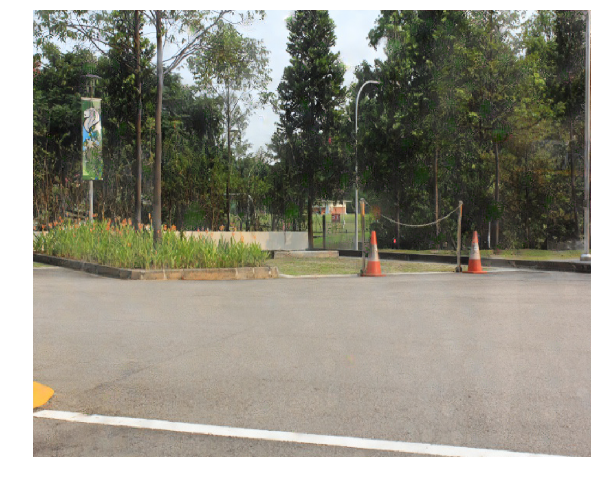

In [16]:
fn = 'test_b/data/128_rain.jpg' #file path
img = open_image(fn); img.shape
_,img_hr,b = learn.predict(img)
show_image(img, figsize=(10,10), interpolation='nearest')
Image(img_hr).show(figsize=(10,10));